# GeoGuessr Artificial Intelligence Model 🌏🌎🌍

In [15]:
# imports
import numpy as np
import cv2 as cv 
import os
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import folium
import random
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# globals
dataset_rel_path = "./data/geotagged_kaggle/streetviews/"
DATASET_ROOT_PATH = os.path.abspath(dataset_rel_path)
map_center = [45, 15]

## Data Loading 📷

The used dataset is based on Google Streetview captures tagged with the latitude and longitude (geoTagged). The images are organized into folders based on the country they are taken from (the name of the folder is the country code).

This model works with the countries from Europe (from the [UN's point of view](https://www.worldometers.info/geography/how-many-countries-in-europe/)). Excluded Russia as most of its surface is not in Europe

In [3]:
europe_countries_code_list = ["AL", "AD", "AT", "BY", "BE", "BA", "BG", "HR", "CZ", "DK", "EE", "FI", "FR", 
                              "DE", "GR", "VA", "HU", "IS", "IE", "IT", "LV", "LI", "LT", "LU", "MT", "MD", 
                              "MC", "ME", "NL", "MK", "NO", "PL", "PT", "RO", "SM", "RS", "SK", "SI", "ES", 
                              "SE", "CH", "UA", "GB"]

### Data Insights
Let's take a look at the number of images in each folder.

In [47]:
def count_files_in_dir(dir_path):
    return len(os.listdir(dir_path))

def display_number_of_images_in_each_folder():
    country_nr_images = {}
    for country_folder in os.listdir(DATASET_ROOT_PATH):
        if (country_folder in europe_countries_code_list):
            country_nr_images[country_folder] = len(os.listdir(os.path.join(DATASET_ROOT_PATH, country_folder)))

    plt.bar(country_nr_images.keys(), country_nr_images.values())
    plt.xlabel("Country")
    plt.xticks(rotation=90)
    plt.ylabel("Nr of Images")
    plt.show()

    print("European countries that are not in the dataset: ")
    print([elem for elem in list(country_nr_images.keys()) + europe_countries_code_list if elem not in country_nr_images.keys()])

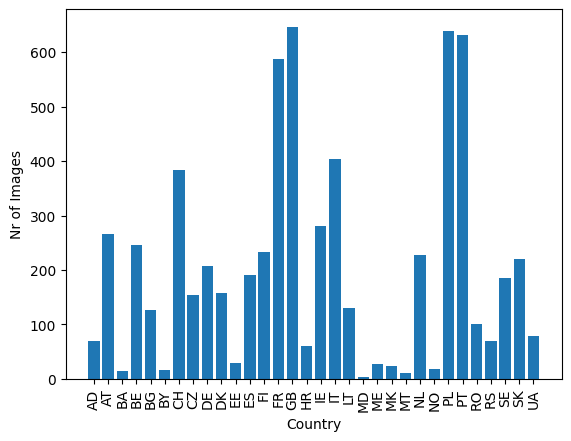

European countries that are not in the dataset: 
['AL', 'GR', 'VA', 'HU', 'IS', 'LV', 'LI', 'LU', 'MC', 'SM', 'SI']


In [48]:
display_number_of_images_in_each_folder()

Let's also plot the report of number of images over the total country surface to observe any imbalances.

In [ ]:
european_country_surface_areas = {
    'AL': 28748,  # Albania
    'AD': 468,    # Andorra
    'AT': 83879,  # Austria
    'BY': 207600, # Belarus
    'BE': 30528,  # Belgium
    'BA': 51197,  # Bosnia and Herzegovina
    'BG': 110879, # Bulgaria
    'HR': 56594,  # Croatia
    'CY': 9251,   # Cyprus
    'CZ': 78865,  # Czech Republic
    'DK': 42924,  # Denmark
    'EE': 45227,  # Estonia
    'FI': 338424, # Finland
    'FR': 551695, # France
    'DE': 357022, # Germany
    'GR': 131957, # Greece
    'HU': 93030,  # Hungary
    'IS': 103000, # Iceland
    'IE': 70273,  # Ireland
    'IT': 301340, # Italy
    'LV': 64589,  # Latvia
    'LI': 160,    # Liechtenstein
    'LT': 65300,  # Lithuania
    'LU': 2586,   # Luxembourg
    'MK': 25713,  # North Macedonia
    'MT': 316,    # Malta
    'MD': 33843,  # Moldova
    'MC': 2,      # Monaco
    'ME': 13812,  # Montenegro
    'NL': 41543,  # Netherlands
    'NO': 1487290,# Norway
    'PL': 312696, # Poland
    'PT': 92212,  # Portugal
    'RO': 238397, # Romania
    'RU': 17098242,# Russia
    'SM': 61,     # San Marino
    'RS': 77474,  # Serbia
    'SK': 49037,  # Slovakia
    'SI': 20273,  # Slovenia
    'ES': 505992, # Spain
    'SE': 450295, # Sweden
    'CH': 41284,  # Switzerland
    'UA': 603500, # Ukraine
    'GB': 243610, # United Kingdom
    'VA': 0.44,   # Vatican City
}

In [51]:
def show_density_of_images_per_country():
    filtered_european_country_surface_areas = {key: european_country_surface_areas[key] for key in country_nr_images.keys()}

    for country_code in country_nr_images.keys():
        filtered_european_country_surface_areas[country_code] = country_nr_images[country_code] / filtered_european_country_surface_areas[country_code] * 100

    plt.bar(country_nr_images.keys(), filtered_european_country_surface_areas.values())
    plt.xlabel("Country")
    plt.xticks(rotation=90)
    plt.ylabel("Nr of Images")
    plt.show()

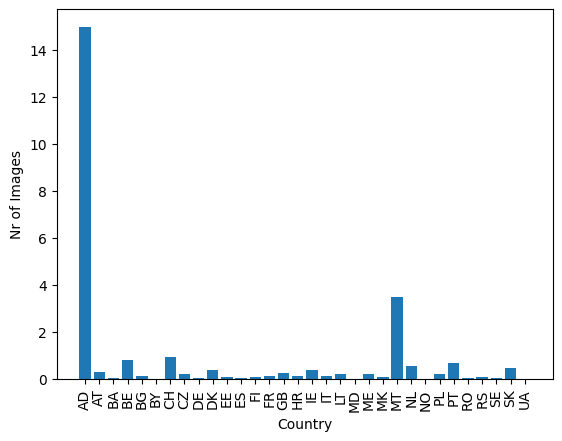

In [52]:
show_density_of_images_per_country()

**Important cell to run!**

We save the image data into a pandas dataframe `all_countries_df` containing the path to the image, the latitude and the longitude.

In [4]:
coordinates_data = {
    'path': [],
    'long': [],
    'lat': []
}

for country_folder in os.listdir(DATASET_ROOT_PATH):
    if (country_folder in europe_countries_code_list):
        curr_path = os.path.join(DATASET_ROOT_PATH, country_folder)
        for filename in os.listdir(curr_path):
            curr_lat, curr_long = filename[: -4].split(',')
            coordinates_data['path'].append(os.path.join(curr_path, filename))
            coordinates_data['lat'].append(float(curr_lat))
            coordinates_data['long'].append(float(curr_long))

all_countries_df = pd.DataFrame(coordinates_data)
all_countries_df.head()

,path,long,lat
0,c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...,1.87154,42.02136
1,c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...,1.88966,42.02381
2,c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...,1.88094,42.02883
3,c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...,1.30027,42.04606
4,c:\Facultate\An_4\An_4_Sem_1\Pattern_Recogniti...,1.84825,42.07719


Let's visualize the geographic distribution of images (folium)

In [56]:
def create_map_with_markers(path):
    my_map = None
    map_center = [45, 15]
    my_map = folium.Map(location=map_center, zoom_start=5)

    # Add markers for each coordinate
    for coordinates in list(zip(all_countries_df.lat, all_countries_df.long)):
        folium.CircleMarker(location=(coordinates[0], coordinates[1]), radius=1).add_to(my_map)

    # Save the map as an HTML file
    my_map.save(path)
    return my_map

In [58]:
map = create_map_with_markers("./maps/map_with_markers.html")

### What kind of data is needed in the model?
#### Data preprocessing
Preprocessing is strongly tied to the choice of the model used (CNN / Vision transformer / Deep neural networks), therefore it may be adapted later in the implementation

Let us first prepare the input data for being fed into a Convolutional Neural Network. This type of network expects a 4D Tensor. For a colored image, this tensor would have the shape
```
[BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUMBER_OF_CHANNELS]
```

The images will be preprocessed as follows:
- resize to the STANDARD_SIZE in this case 256 pixels for an edge (square shape)
- normalize the image

In [6]:
# OpenCV understanding on how images are processed
example_img = cv.imread(os.path.join(dataset_rel_path, "CH/45.72656,6.52431.jpg"))
print(type(example_img))
print(np.shape(example_img))

# resize
resized = cv.resize(example_img, (STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE), interpolation=cv.INTER_NEAREST)
print(np.shape(resized))
print(resized[0][0]) # print the color channels B G R

cv.imshow("original", example_img)
cv.imshow("resized", resized)
cv.waitKey(0)

#### Image Labeling, creating dataset, splitting into test, train, validation sets
We need to get from the current state of the data to the data suitable for training, validation and testing.
- *current* state: jpg images aranged into folders and labeled with their latitude and longitude values 
- *desired* state: individual examples consisting of numpy arrays of the required shape, populated with the RGB channels values, and labeled with an integer corresponding to the area on the map where they belong.

Data Structures for the Images:
- x_train, x_validate, x_test: arrays containing the pixel data of the images (will be fed into the neural network)
- y_train, y_validate, y_test: arrays containing the label of each example.

> Note: The label and the example need to be at the same index in the data structures that hold them. Therefore, they need to be shuffled together

##### Obtaining the output labels - (Method 1) **Variable-sized rectangles in a grid** ⏹
In this method the map of europe will be divided into square shapes, therefore the label of an image is the index of the square into the ordered list of squares. The size of the square is determined by the number of training examples in that square. Therefore if it exceeds the `THRESHOLD` it will be split into 4 (its size is reduced). Obtaining these squares is a subproblem on its own and will be solved in the following part.

In [7]:
# Helper functions
INITIAL_SQUARE_EDGE_SIZE = 10
POINTS_IN_SQUARE_TH = 300

all_countries_labeled = []

def isInBbox(point_coords, bottom_left, size):
    if (point_coords[0] > bottom_left[0] and point_coords[0] < bottom_left[0] + size):
        if (point_coords[1] > bottom_left[1] and point_coords[1] < bottom_left[1] + size):
            return True
    return False

def updateLabelForElement(countries_labeled, new_point):
    for index, element in enumerate(countries_labeled):
        if element['path'] == new_point['path']:
            countries_labeled[index]['label'] = new_point['label']
            break
    return countries_labeled

def getSquaresFromArea(countries_labeled, bottom_left, size, points_df, len_squares):
    squares_list = []
    squares_list_len = 0

    bottom_left_x = bottom_left[0]
    while bottom_left_x < (bottom_left[0] + 2 * size):
        bottom_left_y = bottom_left[1]
        while bottom_left_y < (bottom_left[1] + 2 * size):
            count_points = 0
            curr_points_df = []    
            for index, point in all_countries_df.iterrows():
                if isInBbox((point['long'], point['lat']), (bottom_left_x, bottom_left_y), size):
                    count_points += 1
                    curr_points_df.append(point)
                    new_point = {
                        'path': point['path'],
                        'label': len_squares + squares_list_len
                    }
                    countries_labeled = updateLabelForElement(countries_labeled, new_point)

            if count_points >= POINTS_IN_SQUARE_TH:
                # break up the square even more
                countries_labeled, squares_list_from_area = (getSquaresFromArea(countries_labeled, (bottom_left_x, bottom_left_y), size / 2, points_df, len_squares + squares_list_len))
                squares_list_len += len(squares_list_from_area)
                squares_list += squares_list_from_area

            elif count_points > 0:
                squares_list.append((bottom_left_x, bottom_left_y, size))
                squares_list_len += 1
            bottom_left_y += size
        bottom_left_x += size
    return countries_labeled, squares_list

In [ ]:
europe_bbox = {
    'lat_min': 36.03,
    'lat_max': 71.13,
    'long_min': -10.72,
    'long_max': 41.31
}

squares = []
squares_len = 0

bottom_left_x = europe_bbox['long_min']
while(bottom_left_x < europe_bbox['long_max']):
    bottom_left_y = europe_bbox['lat_min']

    while (bottom_left_y < europe_bbox['lat_max']):
        count_points = 0
        curr_points_df = []
        
        for index, point in all_countries_df.iterrows():
            if isInBbox((point['long'], point['lat']), (bottom_left_x, bottom_left_y), INITIAL_SQUARE_EDGE_SIZE):
                curr_points_df.append(point)
                count_points += 1
                point['label'] = squares_len
                all_countries_labeled.append(point)

        if count_points >= POINTS_IN_SQUARE_TH:
            # break the square even more
            all_countries_labeled, squares_in_area = getSquaresFromArea(all_countries_labeled, (bottom_left_x, bottom_left_y), INITIAL_SQUARE_EDGE_SIZE / 2, pd.DataFrame(curr_points_df), squares_len)
            squares_len += len(squares_in_area)
            squares += squares_in_area

        elif (count_points > 0):
            squares.append((bottom_left_x, bottom_left_y, INITIAL_SQUARE_EDGE_SIZE))
            squares_len += 1
        
        bottom_left_y += INITIAL_SQUARE_EDGE_SIZE
    
    bottom_left_x += INITIAL_SQUARE_EDGE_SIZE
       
labeled_examples_df = pd.DataFrame(all_countries_labeled) # {path to image, label}

In [ ]:
print(labeled_examples_df.head())

Display the map with the grid (using folium)

In [12]:
my_map = folium.Map(location=map_center, zoom_start=5)

for index, square in enumerate(squares):
    folium.Rectangle(
        bounds=[[square[1], square[0]], [square[1] + square[2], square[0] + square[2]]], # long lat (y x)
        fill=False,
        color='orange',
        fill_color='orange',
        fill_opacity=0.1,
        popup=f'{index}'
    ).add_to(my_map)

# Add markers for each coordinate
for coordinates in list(zip(labeled_examples_df.lat, labeled_examples_df.long, labeled_examples_df.label)):
    folium.CircleMarker(location=(coordinates[0], coordinates[1]), radius=2, popup=coordinates[2]).add_to(my_map)


my_map.save('./maps/map_w_rectangular_grid.html') # Remark: squares appear as rectangles due to map projection

##### Obtaining the output labels - (Method 2) **K clusters - using K-means clustering**

In [5]:
# Euclidean distance
def distance(pos_from, pos_to):
    return np.sqrt((pos_from[0] - pos_to[0]) ** 2 + (pos_from[1] - pos_to[1]) ** 2)    

# K means clustering algorithm - specific for our dataset
def kMeansClustering(k, countries_df, max_iterations, initial_centers=None):
    if initial_centers is not None:
        centers = initial_centers.copy()
    else:
        centers = countries_df.sample(n=k)
        centers.reset_index(inplace=True, drop=True)
    
    membership_function = np.arange(len(countries_df))
    
    for iteration in range(max_iterations):
        # save previous membership function
        membership_prv = np.copy(membership_function)
        # compute new membership function
        for index, point in countries_df.iterrows():
            min_distance = distance((point['long'], point['lat']), (centers.iloc[0]['long'], centers.iloc[0]['lat']))
            membership_function[index] = 0
            for index_center, center in centers.iterrows():
                curr_distance = distance((point['long'], point['lat']), (center['long'], center['lat']))
                if curr_distance < min_distance:
                    min_distance = curr_distance
                    membership_function[index] = index_center
        # compute new centers
        clusters_count = np.zeros(k)
        for index, point in countries_df.iterrows():
            cluster = membership_function[index]
            clusters_count[cluster] += 1
            centers.iloc[cluster]['long'] = centers.iloc[cluster]['long'] + point['long']
            centers.iloc[cluster]['lat'] = centers.iloc[cluster]['lat'] + point['lat']
        # normalize centers
        for index, center in centers.iterrows():
            centers.iloc[index]['long'] /= clusters_count[index]
            centers.iloc[index]['lat'] /= clusters_count[index]
        # stopping condition
        if np.array_equal(membership_function, membership_prv):
            break

    return membership_function, centers                          
    

In [ ]:
membership, centers = kMeansClustering(10, all_countries_df, 1000)

In [26]:
map_center = [45, 15]
my_map = folium.Map(location=map_center, zoom_start=5)

rand_colors = []
available_colors = ['blue', 'green', 'purple', 'orange', 'darkblue', 'darkgreen', 'lightgreen', 'pink', 'black', 'darkgrey']

for i in range(len(centers)):
    rand_color = random.choice(available_colors)
    rand_colors.append(rand_color)
    available_colors.remove(rand_color)

# add all points colored with random colors w.r.t. their cluster
for index, coordinates in enumerate(list(zip(all_countries_df.lat, all_countries_df.long))):
    folium.CircleMarker(location=(coordinates[0], coordinates[1]), radius=2, popup=index, color = rand_colors[membership[index]]).add_to(my_map)

for index, center in centers.iterrows():
    # colored with red
    folium.CircleMarker(location=(center['lat'], center['long']), radius=2, popup='center', color = 'red').add_to(my_map)

my_map.save('./maps/map_w_k_clusters.html')

NameError: name 'centers' is not defined

> Remark: this is not the desired result (would not make sense from the geographical point of view). Another way to label the samples is to perform just the initialization step of the k_means clustering algorithm having
some centers chosen manually (based on the distribution of the input data and on the geographical characteristics of Europe).

##### Obtaining the output labels - (Method 3) 👌🏽**Hand-picked cluster centers & 1 iteration of k-means**

In [6]:
initial_centers = pd.DataFrame({
    'long': np.empty(6),
    'lat': np.empty(6)
})

initial_centers.iloc[0]['long'] = -1.27 # Oxford
initial_centers.iloc[0]['lat'] = 51.75

initial_centers.iloc[1]['long'] = -3.72 # Madrid
initial_centers.iloc[1]['lat'] = 40.39

# Zadar (Croatia)
initial_centers.iloc[2]['long'] = 15.22
initial_centers.iloc[2]['lat'] = 44.12

initial_centers.iloc[3]['long'] = 30.98 # Gomel (Belarus)
initial_centers.iloc[3]['lat'] = 52.43

# Liberec (Czech Republic)
initial_centers.iloc[4]['long'] = 15.06
initial_centers.iloc[4]['lat'] = 50.77

# vasterviks kommun (Sweden)
initial_centers.iloc[5]['long'] = 16.64
initial_centers.iloc[5]['lat'] = 57.76

my_map = folium.Map(location=map_center, zoom_start=5)
for index, center in initial_centers.iterrows():
    folium.CircleMarker(location=(center['lat'], center['long']), radius=2, color = 'red').add_to(my_map)

my_map.save('./maps/map_w_handpicked_centers.html')

In [7]:
membership, centers = kMeansClustering(6, all_countries_df, 1, initial_centers)

In [32]:
map_center = [45, 15]
my_map = folium.Map(location=map_center, zoom_start=5)

rand_colors = []
available_colors = ['blue', 'green', 'purple', 'orange', 'darkblue', 'darkgreen', 'lightgreen', 'pink', 'black']

for i in range(len(centers)):
    rand_color = random.choice(available_colors)
    rand_colors.append(rand_color)
    available_colors.remove(rand_color)

# add all points colored with random colors w.r.t. their cluster
for index, coordinates in enumerate(list(zip(all_countries_df.lat, all_countries_df.long))):
    folium.CircleMarker(location=(coordinates[0], coordinates[1]), radius=2, popup=membership[index], color = rand_colors[membership[index]]).add_to(my_map)

for index, center in initial_centers.iterrows():
    # colored with red
    folium.CircleMarker(location=(center['lat'], center['long']), radius=2, popup='center', color = 'red').add_to(my_map)

my_map.save('./maps/map_w_cluster_handpicked_centers.html')

By visualizing all three methods we notice that the best option from an intuitive perspective is the last one. Therefore, despite some of its disadvantages we take it into account. 

Some possible improvements for the dataset labeling are
* forcing points that are close together (in the visible aglomerations on the map) to belong to the same cluster. (how to choose the cluster they belong to though?)
* adding some more labels in the crowded areas (e.g UK & Ireland different from Benelux & France)

There actually exists a in tensorflow method called `image_dataset_from_directory` which creates a data set from images placed in a folder structure such that images in the same class are in the same folder. Experimentally this has been proven as a much more efficient (can't be compared) than creating a CSV with all data (its size goes up to a few GB depending on the image size).

The function is a great option as it also shuffles and splits the data into train/validation partitions, transforms the class to one-hot format, and splits the dataset into batches, leveraging parallelism and memory usage efficiency.

Therefore, the next cells which create numpy arrays saved in csv can and should be skipped. The commented code is left here in case one would like to load the images from csv.

In [9]:
STANDARD_IMAGE_SIZE = 224
# Building the labeled dataset
x_all = np.empty((len(all_countries_df), STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE, 3))
y_all = np.empty((len(all_countries_df)))

for index, point in all_countries_df.iterrows():
    image = cv.imread(point['path'])
    image = cv.resize(image, (STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE), interpolation=cv.INTER_NEAREST)
    x_all[index] = image
    y_all[index] = membership[index]

# # save the data to csv
# x_df = pd.DataFrame(x_all.reshape(len(all_countries_df), -1))
# y_df = pd.DataFrame(y_all.reshape(len(all_countries_df), -1))
# x_df = x_df.astype('int32')
# y_df = y_df.astype('int32')
# # y_df.to_csv('./data/y_all.csv', index=False)
# x_df.to_csv('./data/x_64_all.csv', index=False)

Placing images in directories corresponding to their class (the more efficient option). Also split them into test and training directories right from the beginning

In [80]:
STANDARD_IMAGE_SIZE = 224

os.makedirs(f'./data/images_{STANDARD_IMAGE_SIZE}_all', exist_ok=True)
for i in range(6):
    os.makedirs(f'./data/images_{STANDARD_IMAGE_SIZE}_all/{i}',exist_ok=True)

paths = []
labels = []

for index, point in all_countries_df.iterrows():
    image_path = point['path']
    paths.append(image_path)
    labels.append(int(membership[index]))

train_photos, test_photos, train_labels, test_labels = train_test_split(paths, labels, test_size=0.1, random_state=42, stratify=labels)

train_directory = f'./data/{STANDARD_IMAGE_SIZE}/train'
test_directory = f'./data/{STANDARD_IMAGE_SIZE}/test'

os.makedirs(train_directory, exist_ok=True)
for i in range(6):
    os.makedirs(os.path.join(train_directory, f'{i}'), exist_ok=True)
os.makedirs(test_directory, exist_ok=True)
for i in range(6):
    os.makedirs(os.path.join(test_directory, f'{i}'), exist_ok=True)

count = 0
for path, label in zip(train_photos, train_labels):
    image = cv.imread(path)
    image = cv.resize(image, (STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE), interpolation=cv.INTER_NEAREST)
    final_path =  os.path.join(train_directory, f'{label}/{count}.jpg')
    cv.imwrite(final_path, image)
    count += 1

count = 0
for path, label in zip(test_photos, test_labels):
    image = cv.imread(path)
    image = cv.resize(image, (STANDARD_IMAGE_SIZE, STANDARD_IMAGE_SIZE), interpolation=cv.INTER_NEAREST)
    final_path =  os.path.join(test_directory, f'{label}/{count}.jpg')
    cv.imwrite(final_path, image)
    count += 1

In [81]:
# verify all images were placed in folders STANDARD_SIZE/train or test/class/image.jpg sum up all images and compare to len of df with for loops
sum = 0
for i in range(6):
    sum += len(os.listdir(os.path.join(train_directory, f"{i}"))) +len(os.listdir(os.path.join(test_directory, f"{i}")))
    print(f'Number of images in train/{i}: {len(os.listdir(os.path.join(train_directory, f"{i}")))}')
    print(f'Number of images in test/{i}: {len(os.listdir(os.path.join(test_directory, f"{i}")))}')
print(sum)


Number of images in train/0: 1759
Number of images in test/0: 195
Number of images in train/1: 923
Number of images in test/1: 103
Number of images in train/2: 904
Number of images in test/2: 100
Number of images in train/3: 366
Number of images in test/3: 41
Number of images in train/4: 1228
Number of images in test/4: 137
Number of images in train/5: 615
Number of images in test/5: 68
6439


### Shuffling and splitting into Test, Validation, and Training sets

We need to divide the dataset into Test, Validation and Training set. We choose the percentages:
* 80% training
* 10% validation
* 10% test

For shuffling the data set in a way that ensures all labels are well represented we can take advantage of the `sklearn` method `train_test_split`

> This should be run in Google Colab (or similar), as it takes a while on the local machine

## Training the Neural Networks
We will train and test multiple network architectures and observe their behavior in out classification problem. Moreover, as the required computational resources are significant we will use various image sizes, and leverage transfer learning (using pre-trained models that are fine-tuned on our data).

In [4]:
# import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input, Dropout, Lambda, Rescaling, BatchNormalization
from keras.layers import RandomFlip, RandomCrop, RandomZoom, RandomRotation, RandomTranslation, RandomBrightness
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow import random
from keras.losses import SparseCategoricalCrossentropy
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

c:\Downloaded_Apps\Anaconda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

### Dummy classifier
Let's first observe how a random classifier would work on the input data if it were to only choose a class randomly. This will be considered a baseline for the performance of our networs. (in the way that if a network performs worse than the random classifier, it is a terrible model)

In [10]:
x_dummy_train, x_dummy_test, y_dummy_train, y_dummy_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all)

In [16]:
random_classifier = DummyClassifier(strategy='uniform')
random_classifier.fit(x_dummy_train, y_dummy_train)
y_pred_random = random_classifier.predict(x_dummy_test)

accuracy_random = accuracy_score(y_dummy_test, y_pred_random)

print("Random Classifier Accuracy:", accuracy_random)

Random Classifier Accuracy: 0.16614906832298137


In [ ]:
# drive paths
PLOT_PATH = "./drive/MyDrive/Colab_Data/plotsFinal"
INPUT_224_PATH = "./drive/MyDrive/Colab_Data/224"
INPUT_64_PATH = "./drive/MyDrive/Colab_Data/64"
MODELS_PATH = "./drive/MyDrive/Colab_Data/models"

In [ ]:
# utility functions
def plot_accuracy_loss_subplt(history, title, path, fig_size):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
  ax1.plot(history.history['accuracy'], label='Model Accuracy')
  ax1.plot(history.history['val_accuracy'])
  ax1.legend(['train', 'test'])
  #ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax2.plot(history.history['loss'], label='Model Loss')
  ax2.plot(history.history['val_loss'])
  ax2.legend(['train', 'test'])
  #ax2.set_xlabel('epoch')
  ax2.set_ylabel('loss')
  plt.subplots_adjust(hspace=0.9)
  plt.title(title)
  plt.savefig(path)
  files.download(path)
  plt.show()

In [ ]:
### Data loading in drive
test_ds_224 = image_dataset_from_directory(f"{INPUT_224_PATH}/test",
                                        labels="inferred",
                                        label_mode="categorical",
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(224,224),
                                        seed=42)
test_ds_64 = image_dataset_from_directory(f"{INPUT_224_PATH}/test",
                                        labels="inferred",
                                        label_mode="categorical",
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(64,64),
                                        seed=42)                    

In [ ]:
train_ds_224 = image_dataset_from_directory(f"{INPUT_224_PATH}/train",
                                        labels="inferred",
                                        label_mode="categorical",
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(224,224),
                                        shuffle=True,
                                        validation_split=0.111111,
                                        subset="training",
                                        seed=42)

val_ds_224 = image_dataset_from_directory(f"{INPUT_224_PATH}/train",
                                        labels="inferred",
                                        label_mode="categorical",
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(224,224),
                                        shuffle=True,
                                        validation_split=0.111111,
                                        subset="validation",
                                        seed=42)

train_ds_224 = train_ds_224.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_224 = val_ds_224.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds_64 = image_dataset_from_directory(f"{INPUT_64_PATH}/train",
                                        labels="inferred",
                                        label_mode="categorical",
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(224,224),
                                        shuffle=True,
                                        validation_split=0.111111,
                                        subset="training",
                                        seed=42)

val_ds_64 = image_dataset_from_directory(f"{INPUT_64_PATH}/train",
                                        labels="inferred",
                                        label_mode="categorical",
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(224,224),
                                        shuffle=True,
                                        validation_split=0.111111,
                                        subset="validation",
                                        seed=42)

train_ds_64 = train_ds_64.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_64 = val_ds_64.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# common for augmentation
augmentation_layers = Sequential(name="Augmentation")
augmentation_layers.add(RandomFlip("horizontal"))
augmentation_layers.add(RandomTranslation((-0.1, 0.1), (-0.2, 0.2)))

### Custom Simple Architecture
Let's first train the model on a network comprised of 3 convolutional layers, 3 pooling layers and a dense neural network.

#### 64 x 64 Images

In [ ]:
cnn_simple_model_64 = Sequential(name="Simple_CNN_64")
cnn_simple_model_64.add(Input(shape=(64, 64, 3)))
cnn_simple_model_64.add(Rescaling(1./255))

# CNN
cnn_simple_model_64.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding="same", activation="relu"))
cnn_simple_model_64.add(MaxPooling2D(2))

cnn_simple_model_64.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding="same", activation="relu"))
cnn_simple_model_64.add(MaxPooling2D(2))

# DNN
cnn_simple_model_64.add(Flatten())
cnn_simple_model_64.add(Dense(units=128, activation="relu"))
cnn_simple_model_64.add(Dense(units=64, activation="relu"))
cnn_simple_model_64.add(Dense(units=6, activation="softmax"))
cnn_simple_model_64.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_simple_model_64.summary()

In [ ]:
history = cnn_simple_model_64.fit(x=train_ds_64, validation_data = val_ds_64, epochs=30)

In [ ]:
plot_accuracy_loss_subplt(history, "64x64 CNN Simple", "./drive/MyDrive/An_IV/PRS/plotsFinal/cnn_simple_64.jpg", (10, 3))

##### Adding regularization

In [ ]:
cnn_simple_model_reg_64 = Sequential(name="Simple_CNN_64_Normalized")
cnn_simple_model_reg_64.add(Input(shape=(224, 224, 3)))
cnn_simple_model_reg_64.add(Rescaling(1./255))
cnn_simple_model_reg_64.add(augmentation_layers)

# CNN
cnn_simple_model_reg_64.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_simple_model_reg_64.add(MaxPooling2D(2))

cnn_simple_model_reg_64.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_simple_model_reg_64.add(MaxPooling2D(2))

# DNN
cnn_simple_model_reg_64.add(Flatten())
cnn_simple_model_reg_64.add(Dense(units=128, activation="relu"))
cnn_simple_model_reg_64.add(Dropout(0.25))
cnn_simple_model_reg_64.add(Dense(units=64, activation="relu"))
cnn_simple_model_reg_64.add(Dropout(0.25))
cnn_simple_model_reg_64.add(Dense(units=6, activation="softmax"))
cnn_simple_model_reg_64.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_simple_model_reg_64.summary()

In [ ]:
history = cnn_simple_model_reg_64.fit(x=train_ds_64, validation_data = val_ds_64, epochs=30)

In [ ]:
plot_accuracy_loss_subplt(history, "64x64 CNN Simple Regularized", f"{PLOT_PATH}/cnn_simple_reg_64.jpg", (10, 3))

#### 224 x 224 Images

In [ ]:
# Simple CNN model
cnn_simple_224 = Sequential(name="Simple_CNN_64")
cnn_simple_224.add(Input(shape=(224, 224, 3)))
cnn_simple_224.add(Rescaling(1./255))

# CNN
cnn_simple_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_simple_224.add(MaxPooling2D(2))

cnn_simple_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_simple_224.add(MaxPooling2D(2))

# DNN
cnn_simple_224.add(Flatten())
cnn_simple_224.add(Dense(units=128, activation="relu"))
cnn_simple_224.add(Dense(units=64, activation="relu"))
cnn_simple_224.add(Dense(units=6, activation="softmax"))
cnn_simple_224.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_simple_224.summary()

In [ ]:
history = cnn_simple_224.fit(train_ds_224, validation_data=val_ds_224, epochs=30)

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 CNN Simple", f"{PLOT_PATH}/cnn_simple_224.jpg", (10, 3))

<img src=./data/plotsFinal/cnn_simple_224.jpg>

In [ ]:
cnn_simple_224.save(f"{MODELS_PATH}/cnn_simple_224.keras")

#### Adding regularization

In [ ]:
# Simple CNN model
cnn_simple_norm_224 = Sequential(name="Simple_CNN_224_Regularized")
cnn_simple_norm_224.add(Input(shape=(224, 224, 3)))
cnn_simple_norm_224.add(Rescaling(1./255))
cnn_simple_norm_224.add(augmentation_layers)

# CNN
cnn_simple_norm_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_simple_norm_224.add(MaxPooling2D(2))

cnn_simple_norm_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_simple_norm_224.add(MaxPooling2D(2))

# DNN
cnn_simple_norm_224.add(Flatten())
cnn_simple_norm_224.add(Dense(units=128, activation="relu"))
cnn_simple_norm_224.add(Dropout(0.25))
cnn_simple_norm_224.add(Dense(units=64, activation="relu"))
cnn_simple_norm_224.add(Dropout(0.25))
cnn_simple_norm_224.add(Dense(units=6, activation="softmax"))
cnn_simple_norm_224.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_simple_norm_224.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callbacks = [early_stop]

history = cnn_simple_norm_224.fit(train_ds_224, batch_size=32, epochs=30, validation_data=val_ds_224, callbacks=my_callbacks)

<img src=./data/plotsFinal/cnn_s_reg_224.jpg>

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 CNN aug norm", f"{PLOT_PATH}/cnn_s_reg_224.jpg", (10, 3))

In [ ]:
cnn_simple_norm_224.save(f"{MODELS_PATH}/cnn_simple_reg_224.keras")

### Custom Deeper Architecture
We add a few additional layers hoping it will help the model differentiate better between classes.
#### 224 x 224 Images
We will test the architecture on this dataset as the larger size allows multiple convolutional layers (as size is not as dramatically decreased).

In [ ]:
cnn_deeper_224 = Sequential(name="Deeper_CNN_64_Normalized")
cnn_deeper_224.add(Input(shape=(224, 224, 3)))
cnn_deeper_224.add(Rescaling(1./255))

# CNN
cnn_deeper_224.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_224.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_224.add(MaxPooling2D(2))

cnn_deeper_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_224.add(MaxPooling2D(2))

cnn_deeper_224.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_224.add(MaxPooling2D(2))

# DNN
cnn_deeper_224.add(Flatten())
cnn_deeper_224.add(Dense(units=128, activation="relu"))
cnn_deeper_224.add(Dense(units=64, activation="relu"))
cnn_deeper_224.add(Dense(units=6, activation="softmax"))
cnn_deeper_224.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_deeper_224.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callbacks = [early_stop]

history = cnn_deeper_224.fit(train_ds_224, batch_size=32, epochs=30, validation_data=val_ds_224, callbacks=my_callbacks)

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 CNN Deep", f"{PLOT_PATH}/cnn_deep_224.jpg", (10, 3))

<img src=./data/plotsFinal/cnn_deep_224.jpg>

In [ ]:
cnn_deeper_224.save(f"{MODELS_PATH}/cnn_deeper_224.keras")

Regularization

In [ ]:
cnn_deeper_reg_224 = Sequential(name="Deeper_CNN_64_Normalized")
cnn_deeper_reg_224.add(Input(shape=(224, 224, 3)))
cnn_deeper_reg_224.add(Rescaling(1./255))
cnn_deeper_reg_224.add(augmentation_layers)

# CNN
cnn_deeper_reg_224.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_reg_224.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_reg_224.add(MaxPooling2D(2))

cnn_deeper_reg_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_reg_224.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_reg_224.add(MaxPooling2D(2))

cnn_deeper_reg_224.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"))
cnn_deeper_reg_224.add(MaxPooling2D(2))

# DNN
cnn_deeper_reg_224.add(Flatten())
cnn_deeper_reg_224.add(Dense(units=128, activation="relu"))
cnn_deeper_reg_224.add(Dropout(0.25))
cnn_deeper_reg_224.add(Dense(units=64, activation="relu"))
cnn_deeper_reg_224.add(Dropout(0.25))
cnn_deeper_reg_224.add(Dense(units=6, activation="softmax"))
cnn_deeper_reg_224.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_deeper_reg_224.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callbacks = [early_stop]

history = cnn_deeper_reg_224.fit(train_ds_224, batch_size=32, epochs=30, validation_data=val_ds_224, callbacks=my_callbacks)

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 CNN Deep Reg", f"{PLOT_PATH}/cnn_deep_reg_224.jpg", (10, 3))

<img src=./data/plotsFinal/cnn_deep_reg_224.jpg>

In [ ]:
cnn_deeper_reg_224.save(f"{MODELS_PATH}/cnn_deeper_reg_224.keras")

### Transfer Learning VGG16
Transfer learning refers to taking advantage of previously trained models that proved successfult for a similar task and fine tuning them using the data.
For this we will only use 224x224 data as it is the standard for models such as VGG16, ResNet, DenseNet201 etc.

In [ ]:
input_layer = Input(shape=(224,224,3))
rescaling = Rescaling(1./255)(input_layer)

In [ ]:
trained_vgg = VGG16(weights="imagenet", include_top=False, input_tensor=rescaling)
trained_vgg.trainable = False
trained_vgg.summary()

In [ ]:
# include the dense neural network at the end
complete_model_vgg = Sequential()
complete_model_vgg.add(trained_vgg)
complete_model_vgg.add(Flatten())
complete_model_vgg.add(Dense(units=40, activation="relu"))
complete_model_vgg.add(Dense(units=20, activation="relu"))
complete_model_vgg.add(Dense(units=6, activation="softmax"))

complete_model_vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
complete_model_vgg.summary()

In [ ]:
history = complete_model_vgg.fit(x=train_ds_224, validation_data=val_ds_224, epochs=30)

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 VGG", f"{PLOT_PATH}/vgg_tf_224.jpg", (10, 3))

<img src=./data/plotsFinal/vgg_tf_224.jpg>

Regularization

In [ ]:
complete_model__vgg_reg = Sequential()
complete_model__vgg_reg.add(augmentation_layers)
complete_model__vgg_reg.add(trained_vgg)
complete_model__vgg_reg.add(Flatten())
complete_model__vgg_reg.add(Dense(units=40, activation="relu"))
complete_model__vgg_reg.add(Dropout(0.05))
complete_model__vgg_reg.add(Dense(units=20, activation="relu"))
complete_model__vgg_reg.add(Dense(units=6, activation="softmax"))

complete_model__vgg_reg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
my_callbacks = [early_stop]

history = complete_model__vgg_reg.fit(x=train_ds_224, validation_data=val_ds_224, epochs=40)

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 VGG", f"{PLOT_PATH}/vgg_tf_reg_224.jpg", (10, 3))

<img src=./data/plotsFinal/vgg_tf_reg_224.jpg>

In [ ]:
complete_model__vgg_reg.save(f"{MODELS_PATH}/vgg_tf_reg_224.keras")

### Transfer Learning DenseNet201

In [ ]:
trained_densenet = DenseNet201(weights="imagenet", include_top=False, input_tensor=rescaling)
trained_densenet.trainable = False

In [ ]:
complete_model_densenet = Sequential()
complete_model_densenet.add(trained_densenet)
complete_model_densenet.add(Flatten())
complete_model_densenet.add(Dense(units=40, activation="relu"))
complete_model_densenet.add(Dense(units=20, activation="relu"))
complete_model_densenet.add(Dense(units=6, activation="softmax"))

complete_model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
complete_model_densenet.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
my_callbacks = [early_stop]

history = complete_model_densenet.fit(x=train_ds_224, validation_data=val_ds_224, epochs=40)

In [ ]:
plot_accuracy_loss_subplt(history, "224x224 DN", f"{PLOT_PATH}/dn_tf_224.jpg", (10, 3))

In [ ]:
complete_model_densenet.save(f"{MODELS_PATH}/dn_tf_224.keras")

# Evaluation
For evaluating each network we run the evaluate method on the test set (which was partitioned at the beginning, and was not used at all until now).

In [ ]:
simple_224_model = load_model(f"{MODELS_PATH}/cnn_simple_224.keras")
test_loss, test_accuracy = simple_224_model.evaluate(test_ds_224, verbose=2)
print('\nSimple Test accuracy: ', test_accuracy)

In [ ]:
simple_reg_224_model = load_model(f"{MODELS_PATH}/cnn_simple_reg_224.keras")
test_loss, test_accuracy = simple_reg_224_model.evaluate(test_ds_224, verbose=2)
print('\nSimple Reg Test accuracy: ', test_accuracy)

In [ ]:
deeper_244_model = load_model(f"{MODELS_PATH}/cnn_deeper_224.keras")
test_loss, test_accuracy = deeper_244_model.evaluate(test_ds_224, verbose=2)
print('\nDeeper Test accuracy: ', test_accuracy)

In [ ]:
deeper_reg_244_model = load_model(f"{MODELS_PATH}/cnn_deeper_reg_224.keras")
test_loss, test_accuracy = deeper_reg_244_model.evaluate(test_ds_224, verbose=2)
print('\nDeeper Test Reg accuracy: ', test_accuracy)

In [ ]:
vgg_reg_model = load_model(f"{MODELS_PATH}/vgg_tf_reg_224.keras")
test_loss, test_accuracy = vgg_reg_model.evaluate(test_ds_224, verbose=2)
print('\nDeeper Test accuracy: ', test_accuracy)

In [ ]:
dnet_model = load_model(f"{MODELS_PATH}/dn_tf_224.keras")
test_loss, test_accuracy = dnet_model.evaluate(test_ds_224, verbose=2)
print('\nDeeper Test accuracy: ', test_accuracy)

|Network Architecture|Hidden test set accuracy|
|-|-|
|Simple CNN 224|26.39%|
|Simple CNN Regularized|35.55%|
|Deeper CNN|34.36%|
|Deeper CNN Regularized|34.78%|
|VGG Regularized|39.28%|
|DenseNet|TBD - 30% approx on validation during training|

### Custom images evaluation pipeline

In [87]:
image = cv.imread(f'./data/1.JPG')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_rgb_resized = cv.resize(image_rgb, (224,224), cv.INTER_NEAREST)
input_tensor = np.expand_dims(image_rgb_resized, axis=0)

In [88]:
vgg_reg_model(input_tensor)

NameError: name 'vgg_reg_model' is not defined